# Cleaning code for "Dynamic Pricing for Online Marketplace Sales"
### Daniel Guetta

This file contains suggested code you might run as part of your study of the "Dynamic Pricing for Online Marketplace Sales" case. It is by no means the only way to address the problem, and the author would be grateful for any thoughts you have around other ways you might approach the case.

## Import packages

In [1]:
# Dates and times
import datetime as dt

# Pandas
import pandas as pd

# Mathematics
import numpy as np

# Plots (the first line ensures that you don't need to
# run plt.show() every time you want to show a plot;
# it happens automatically)
%matplotlib inline
import matplotlib.pyplot as plt

# Interpolation
from scipy.interpolate import interp1d

# Package to read from the web for the simulator
import urllib

In [2]:
def argmin(x):
    '''
    This function takes a vector, and returns a list of indicies of the
    entries that are equal to the minimum value of the vector
    '''
    return [ j for (i, j) in zip(x, range(len(x))) if i == min(x) ]

## Load the data

In [3]:
pricing_data = pd.read_csv("../Data/pricing_data.csv", dtype = str)
demand_data =pd.read_csv("../Data/demand_data.csv", dtype = str)

In [4]:
def print_summary():
    print("PRICING DATA")
    print("Shape: " + str(pricing_data.shape))
    display(pricing_data.head())
    
    print("DEMAND DATA")
    print("Shape: " + str(demand_data.shape))
    display(demand_data.head())
    
print_summary()

PRICING DATA
Shape: (155, 4)


,product_id,start_date,end_date,price
0,00057483849381,2017-04-23 21:13:34.120071,2017-04-24 21:31:06.554144,$5.5
1,00057483849381,2017-04-13 21:22:15.140159,2017-04-15 21:18:44.602745,$5.49
2,00057483849381,2017-03-26 22:29:14.864991,2017-03-27 22:17:46.512748,$9.58
3,00057483849381,2017-03-24 22:19:47.090448,2017-03-26 22:29:14.408937,$9.03
4,00057483849381,2017-06-08 23:19:18.184932,2017-06-09 23:02:48.168258,$5.5


DEMAND DATA
Shape: (290, 4)


,product_id,order_id,date_time,quantity
0,57483849381,435723229,03/24/2017 Time: 04-59-10,1
1,57483849381,590234830,02/03/2017 Time: 01-44-42,10
2,57483849381,652912680,02/05/2017 Time: 23-32-43,4
3,57483849381,603830151,03/01/2017 Time: 20-59-05,9
4,57483849381,628238348,03/11/2017 Time: 04-05-09,1


We already see a few problems
  * The product_ids have leading zeroes in the pricing table
  * The dates have different formats
  * The prices have dollar signs in them

## Clean the data

### Check for duplicated rows

In [5]:
def check_duplication(df, df_name):
    num_duplicated = df.duplicated().sum()
    if num_duplicated > 0:
        print ("Detected " + str(num_duplicated) + " duplicate rows in dataframe " + df_name + ". Dropping them.")
        df = df.drop_duplicates()
    
    return df

pricing_data = check_duplication(pricing_data, "pricing_data")
demand_data = check_duplication(demand_data, "demand_data")

Detected 50 duplicate rows in dataframe pricing_data. Dropping them.


### Typecast the data
For each column, we will process all the entries to ensure they are in the right format. We will do this by defining "cleaning" functions that applying them to every row.

If any of the data is not in the format we expect, the cleaning functions will throw an error, thus informing us some invalid data exists.

#### Pricing data

In [6]:
# Check that the product IDs are numbers, and remove leading
# zeroes. Running the product IDs through the int function
# will automatically remove those zeroes, and will error out
# if the product ID is not a number.
def clean_ids(x):
    return int(x)

pricing_data['product_id'] = pricing_data.product_id.apply( clean_ids )

ValueError: invalid literal for int() with base 10: 'KB392RIFD'

In [7]:
# Clearly, some product IDs contain strings. Thus, we should
# modify our function to strip leading zeroes if the ID is a
# number, but otherwise leave it alone
def clean_ids(x):
    try:
        return str(int(x))
    except:
        return x
    
pricing_data['product_id'] = pricing_data.product_id.apply( clean_ids )

In [8]:
# Start date / end date should be dates. Based on what we see
# in the samples above, dates in the pricing table are in the
# following format: '%Y-%m-%d %H:%M:%S.%f'

def clean_dates(x):
    return dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f')
        
pricing_data['start_date'] = pricing_data.start_date.apply( clean_dates )
pricing_data['end_date'] = pricing_data.end_date.apply( clean_dates )

ValueError: time data '2017-02-01 00:00:00' does not match format '%Y-%m-%d %H:%M:%S.%f'

In [9]:
# Unfortunately, it looks like some dates don't have milliseconds.
# Thus, we need to take into account both possible date formats.

def clean_dates(x):
    # Check whether this date includes a millisecond
    if ("." in x):
        return dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f')
    else:
        return dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
pricing_data['start_date'] = pricing_data.start_date.apply( clean_dates )
pricing_data['end_date'] = pricing_data.end_date.apply( clean_dates )

In [10]:
# Price needs to have the dollar sign stripped off, and then needs to be
# converted to a number
pricing_data['price'] = pricing_data.price.apply( lambda x : float(x[1:]) )

In [11]:
pricing_data.head()

,product_id,start_date,end_date,price
0,57483849381,2017-04-23 21:13:34.120071,2017-04-24 21:31:06.554144,5.50
1,57483849381,2017-04-13 21:22:15.140159,2017-04-15 21:18:44.602745,5.49
2,57483849381,2017-03-26 22:29:14.864991,2017-03-27 22:17:46.512748,9.58
3,57483849381,2017-03-24 22:19:47.090448,2017-03-26 22:29:14.408937,9.03
4,57483849381,2017-06-08 23:19:18.184932,2017-06-09 23:02:48.168258,5.50


#### Demand data

In [12]:
# Same processing for product ID
demand_data['product_id'] = demand_data.product_id.apply( clean_ids )

In [13]:
# Convert date_time to a date, using the format in the sample
# above to see if it works
demand_data['date_time'] = demand_data.date_time.apply( lambda x : dt.datetime.strptime(x, '%m/%d/%Y Time: %H-%M-%S') )

In [14]:
# Quantity should be an integer
demand_data['quantity'] = demand_data.quantity.apply( lambda x : int(x) )

ValueError: invalid literal for int() with base 10: '3 cases'

In [15]:
# It seems like one of the rows contains the quantity "3 cases".
# Let's make sure it's not too many rows
sum(demand_data.quantity == "3 cases")

1

In [16]:
# One of the rows contains the quantity "3 cases" which makes
# no sense - let's eliminate it first
demand_data = demand_data[demand_data.quantity != "3 cases"]
demand_data['quantity'] = demand_data.quantity.apply( lambda x : int(x) )

See where we're at

In [17]:
print_summary()

PRICING DATA
Shape: (105, 4)


,product_id,start_date,end_date,price
0,57483849381,2017-04-23 21:13:34.120071,2017-04-24 21:31:06.554144,5.50
1,57483849381,2017-04-13 21:22:15.140159,2017-04-15 21:18:44.602745,5.49
2,57483849381,2017-03-26 22:29:14.864991,2017-03-27 22:17:46.512748,9.58
3,57483849381,2017-03-24 22:19:47.090448,2017-03-26 22:29:14.408937,9.03
4,57483849381,2017-06-08 23:19:18.184932,2017-06-09 23:02:48.168258,5.50


DEMAND DATA
Shape: (289, 4)


,product_id,order_id,date_time,quantity
0,57483849381,435723229,2017-03-24 04:59:10,1
1,57483849381,590234830,2017-02-03 01:44:42,10
2,57483849381,652912680,2017-02-05 23:32:43,4
3,57483849381,603830151,2017-03-01 20:59:05,9
4,57483849381,628238348,2017-03-11 04:05:09,1


### Check for primary keys

In [18]:
print(pricing_data.product_id.value_counts())
print(demand_data.product_id.value_counts())

57483849381    95
KB392RIFD      10
Name: product_id, dtype: int64
57483849381    289
Name: product_id, dtype: int64


It looks like the pricing data has an extraneous product not in the demand data. Remove it

In [19]:
pricing_data = pricing_data[pricing_data.product_id == "57483849381"]
print(pricing_data.product_id.value_counts())
print(demand_data.product_id.value_counts())

57483849381    95
Name: product_id, dtype: int64
57483849381    289
Name: product_id, dtype: int64


Ensure that order_id is a primary key for the demand_data table

In [20]:
demand_data['order_id'].shape[0] -demand_data['order_id'].drop_duplicates().shape[0]

0

Ensure that product ID and start_date are primary keys for the pricing_data table

In [21]:
pricing_data[['product_id', 'start_date']].shape[0] - pricing_data[['product_id', 'start_date']].drop_duplicates().shape[0]

0

We want to make sure that the price table we have covers time continuously with no overlap and no gaps. If there are any gaps, we will extent the end time of the previous period to fill that gap. If there is any overlap, we will push the end time of the previous period back to remove the overlap. If any gap or overlap is greater than 20 seconds, we'll print a warning.

Specifically, we will do this as follows
  * Sort the datframe by start_time
  * Number the rows
  * For each row, bring in the *next* start_time using a join
  * Go through each row and check for overlaps/gaps

In [22]:
# Sort the dataframe and reset the index
pricing_data = pricing_data.sort_values('start_date').reset_index(drop = True)

# Create a second datframe that only contains the start date, and subtract 1
# from its index. When we join the dataframe together on the index, each row
# in pricing_data will be joined to the next row in this new dataframe
right_table = pricing_data[['start_date']].copy()  # Note that .copy() is crucial here, or else we risk modifying
                                                   # the index of the original datframe depending on whether Pandas
                                                   # is returning a view or a copy
right_table.index = right_table.index - 1
right_table.columns = ['next_start_date']

# Join the tables
pricing_data = pd.merge( pricing_data, right_table, how='left', left_index=True, right_index=True )

In [23]:
# Go through our table, and check for gaps
for i, row in pricing_data.iterrows():
    this_gap = ( row['next_start_date'] - row['end_date'] ).total_seconds()
    
    if ( abs(this_gap) > 30 ):
        print("WARNING: detected a gap or overlap greater than 30 seconds. Gap was " + str(round(this_gap, 2)) + " seconds," +\
                 " for period with start_date " + row['start_date'].strftime('%Y-%m-%d %H-%M-%S') + ", ending " +\
                 row['end_date'].strftime('%Y-%m-%d %H-%M-%S') + ". Next period starts at " +\
                                              row['next_start_date'].strftime('%Y-%m-%d %H-%M-%S') )
    
    # Fix the end date of this period to eliminate any gaps or overlaps,
    # unless the next start date is null (this would happen in the last
    # row)
    if (not pd.isnull( row['next_start_date'] )): pricing_data.at[i, 'end_date'] = row['next_start_date']

# We're done with the next_start_date column
del pricing_data['next_start_date']

See where we're at

In [24]:
print_summary()

PRICING DATA
Shape: (95, 4)


,product_id,start_date,end_date,price
0,57483849381,2017-02-01 00:00:00.000000,2017-02-02 00:19:01.440171,3.01
1,57483849381,2017-02-02 00:19:01.440171,2017-02-03 00:19:53.641123,3.13
2,57483849381,2017-02-03 00:19:53.641123,2017-02-05 00:02:34.946427,3.29
3,57483849381,2017-02-05 00:02:34.946427,2017-02-07 00:11:24.754491,3.44
4,57483849381,2017-02-07 00:11:24.754491,2017-02-08 00:05:30.121271,3.57


DEMAND DATA
Shape: (289, 4)


,product_id,order_id,date_time,quantity
0,57483849381,435723229,2017-03-24 04:59:10,1
1,57483849381,590234830,2017-02-03 01:44:42,10
2,57483849381,652912680,2017-02-05 23:32:43,4
3,57483849381,603830151,2017-03-01 20:59:05,9
4,57483849381,628238348,2017-03-11 04:05:09,1


## Explore the data
Now that the data has been cleaned and typed, we're ready to do some preliminary exploration

### Price data

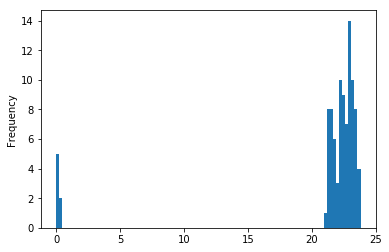

In [25]:
# Find out when price changes tend to happen
pricing_data.start_date.apply( lambda x : x.second/(60*60.0) + x.minute/60.0 + x.hour).plot.hist(bins = 100)

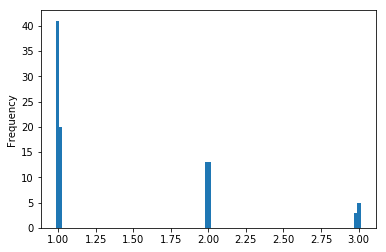

In [26]:
# Find out how long price changes tend to last
pricing_data.apply( lambda x : ( ( x['end_date'] - x['start_date'] ).total_seconds()/(60*60*24.0) ), axis =1 ).plot.hist(bins = 100)

The two previous cells imply that prices tend to always change around midnight, and last a whole number of days. This is good news. It means we don't have to worry about the time of day acting as a confounding factor. In other words, we'll never encounter a situation in which data for one of our price points was collected from 1am - 2am, and data from another price point from 8pm - 9pm, presumably a more popular time.

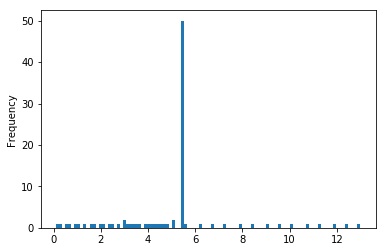

In [27]:
# Look at the distribution of prices (note: this isn't strictly
# speaking right, because it doesn't take into account the fact
# that some prices are in effect for longer than others, but it
# should give us an idea)
pricing_data.price.plot.hist(bins = 100)

0    5.49
dtype: float64


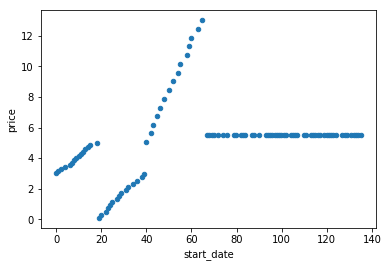

In [28]:
# That plot was useless. Let's try instead to plot the start date
# on the x-axis and the price on the y-axis, to see how the price
# was modified over time
plotting_frame = pricing_data[['start_date', 'price']].copy()
min_date = plotting_frame.start_date.min()
plotting_frame.start_date = plotting_frame.start_date.apply( lambda x : (x - min_date).total_seconds()/(60*60*24.0) )
plotting_frame.plot.scatter(x = 'start_date', y = 'price')
print( plotting_frame.price.mode() )

That makes more sense - it looks like the strategy that was adopted was to scan all prices between \$0 and \$13, and then settle on a price of \$5.49

### Demand data

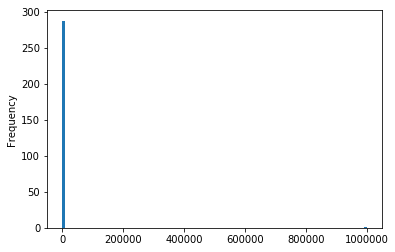

In [29]:
# Look at the distribution of purchased quantities
demand_data.quantity.plot.hist(bins = 100)

In [30]:
# Whoaaaa.... Something looks seriously wrong - we shouldn't be
# selling quantities above 1000! Let's see how many of those we
# have. For good measure, we may as well also look for negative
# demand values
demand_data[ (demand_data.quantity > 1000) | (demand_data.quantity < 0) ]

,product_id,order_id,date_time,quantity
101,57483849381,573728593,2017-02-09,-1
228,57483849381,S3ff@@3,2017-02-05,999999


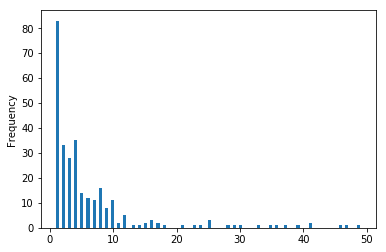

In [31]:
# Looks like we only have one - let's get rid of it and try
# again
demand_data = demand_data[ (demand_data.quantity <= 1000) & (demand_data.quantity >= 0)]
demand_data.quantity.plot.hist(bins = 100)

Much better...

## Estimate a Demand Curve
Now that our data are clean, let's build a master data frame which - for each price - gives the average demand per day for the period the price was active.

There are many ways to do this. Given the size of our data, the most efficient way is as follows
  * We will join the price data and demand data dataframes on product_id. This will result in a datframe in which every single demand point is duplicated for every price point.
  * We will then remove all rows for which the demand point does not fall in the price date range
  * Next, we will aggregate on the start/end date and price, summing the demand
  * Finally, we will find the amount of time during which each price was active, and aggregate on price, summing the demand and period of activity. For each price, this will give us total time period it was active, and total demand
  
Note that if the data were much larger, this would be a shockingly inneficient way of carrying out his operation given the scale of duplication. However, if the data scale were much larger, it would most likely be stored in some sort of more robust data storage infrastructure (eg: hadoop), in which these kinds of large join operations are very efficient.

In [32]:
master_table = pd.merge(pricing_data, demand_data[['product_id', 'date_time', 'quantity']], on ='product_id')

In [33]:
# The master table should have one row per row in each table
master_table.shape[0] - (demand_data.shape[0] * pricing_data.shape[0])

0

In [34]:
# Only keep demands that occured in the date range described in a
# given row
master_table = master_table[ (master_table.date_time > master_table.start_date) &\
                                    (master_table.date_time < master_table.end_date)]

In [35]:
# Because we took great pains to ensure the rows in the pricing
# table covered time with no gaps and no overlaps, every demand
# should be captured in the resulting table once and once only.
# Ensure this is the case
master_table.shape[0] - demand_data.shape[0]

0

In [36]:
# Only keep columns we'll need going forward
master_table = master_table[['start_date', 'end_date', 'price', 'quantity']]

In [37]:
# Aggregate on start_date, end_date, and price, summing over
# quantity
master_table = master_table.groupby(['start_date', 'end_date', 'price']).\
                                apply( lambda x : pd.Series( x.quantity.sum(), index=['total_quantity'] ) ).reset_index()

In [38]:
# Find the number of days each price was active
master_table['days_active'] = ( master_table.end_date - master_table.start_date ).apply( lambda x : x.total_seconds() / (60*60*24.0))

# Drop extraneous columns
master_table = master_table[['price', 'total_quantity', 'days_active']]

In [39]:
# Aggregate for each price, to find the total demand the total number
# of days active
master_table =master_table.groupby('price').\
                                apply( lambda x : pd.Series( [x.total_quantity.sum(), x.days_active.sum()],
                                                                   index = ['total_quantity', 'total_days_active'] ) ).\
                                                                                                                reset_index()

In [40]:
# Finally, find the demand per day and drop extraneous columns
master_table['demand_per_day'] = master_table.total_quantity / master_table.total_days_active

master_table = master_table[['price', 'demand_per_day']]

In [42]:
master_table.to_csv("cleaned_data.csv", index=False)